# Анализ изменения цены лечения в медицинской клинике

![jupyter](ARS_5612.jpg)

## Цель

Провести анализ изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определить ключевые драйверы изменения цены лечения. 

**Определение:** Медицинский кейс - последовательность медицинских услуг, полученных одним застрахованном в одной клинике с интервалом между любыми соседними по дате услугами не более 14 дней. Т.е. между любыми 2-мя услугами в кейсе не должно быть разрыва более 14 дней.

**Определение:** Визит - уникальное сочетание даты оказания услуги, застрахованного. Т.е. один визит - это один день, в который застрахованный побывал в клинике. Если был в одной клинике 2 раза, но в разные дни, то это два визита. Если получал услуги (в любом количестве) в одной клинике в один день, то это один визит.

**Определение:** Обратившийся в месяц - уникальное сочетание месяца оказания услуги и идентификатора пациента

**Гипотезы для проверки:**

1. Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги
2. Средняя стоимость обслуживания пациентов изменилась из-за изменения гендерной структуры обслуживаемых пациентов
3. Средняя стоимость обслуживания пациентов изменилась из-за изменения возрастной структуры обслуживаемых пациентов

## Описание данных

- record_id- уникальный идентификатор строки данных
- service_date - дата оказания медицинской услуги
- service_name - наименование медицинской услуги
- service_number - количество услуг
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- insured - уникальный идентификатор пациента
- sex_id - пол пациента
- age_for_service_date - возраст пациента

Все данные взяты из одной клиники

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from IPython.display import Image, display
import scipy.stats as stats
from scipy import stats as st
import datetime 

In [2]:
df = pd.read_excel(r'C:\Users\123123\Downloads\Pet-projects\datasets\data_test_task_2022.xlsx')

In [3]:
def first_look(df):
    print('---------------------------Первые 5 строк----------------------------')
    display(df.head())
    print(' ')
    print(' ')
    print('--------------Общая информация--------------')
    print(' ')
    print(df.info())
    print(' ')
    print('-------------Пропуски------------- ')
    print(' ')
    count=0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
    if count == 0:
        print(' ')
        print('Пропусков НЕТ')
    print(' ')
    print('-------------Дубликаты------------ ')
    print(' ')
    if df.duplicated().sum() > 0:
        print(' ')
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print(' ')  

In [4]:
first_look(df)

---------------------------Первые 5 строк----------------------------


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


 
 
--------------Общая информация--------------
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB
None
 
-------------Пропуски------------- 
 
sex_id  -  21 пропусков
 
-------------Дубликаты------------ 
 
Дубликатов НЕТ
 


## Предобработка данных

In [5]:
# преобразуем типы данных
df['service_date'] = pd.to_datetime(df['service_date'])

# добавим столбец с годом предоставления услуги
df['service_year'] = df['service_date'].to_numpy().astype('datetime64[Y]')

# переименуем столбец
df = df.rename(columns={'service_number':'cnt_service'})

**Разберёмся с пропусками**

In [6]:
# варианты sex_id
df['sex_id'].value_counts()

2.0    52804
1.0    32544
Name: sex_id, dtype: int64

In [7]:
# незаполненные значения sex_id
df.query('sex_id != sex_id')

,record_id,service_date,service_name,service_amount,cnt_service,insured,sex_id,age_for_service_date,service_year
4411,30489299203,2021-03-18,Прием первичный,1470,1,512590,NaN,26,2021-01-01
4412,30489299303,2021-03-27,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,512590,NaN,26,2021-01-01
4413,30489299403,2021-03-27,Общий анализ мочи,431,1,512590,NaN,26,2021-01-01
4414,30489299503,2021-03-27,Альфа-амилаза панкреатическая,287,1,512590,NaN,26,2021-01-01
4415,30489299603,2021-03-27,АЛТ (аланинаминотрансфераза),278,1,512590,NaN,26,2021-01-01
4416,30489299703,2021-03-27,АСТ (аспартатаминотрансфераза),242,1,512590,NaN,26,2021-01-01
4417,30489299803,2021-03-27,Билирубин общий,287,1,512590,NaN,26,2021-01-01
4418,30489299903,2021-03-27,ГГТ (гамма - глютамилтрансфераза),287,1,512590,NaN,26,2021-01-01
4419,30489300003,2021-03-27,Глюкоза крови,273,1,512590,NaN,26,2021-01-01
4420,30489300103,2021-03-27,Фосфотаза щелочная,287,1,512590,NaN,26,2021-01-01


In [8]:
# просмотрим все обращения застрахованного №512590
df.query('insured == 512590')

,record_id,service_date,service_name,service_amount,cnt_service,insured,sex_id,age_for_service_date,service_year
4411,30489299203,2021-03-18,Прием первичный,1470,1,512590,NaN,26,2021-01-01
4412,30489299303,2021-03-27,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,512590,NaN,26,2021-01-01
4413,30489299403,2021-03-27,Общий анализ мочи,431,1,512590,NaN,26,2021-01-01
4414,30489299503,2021-03-27,Альфа-амилаза панкреатическая,287,1,512590,NaN,26,2021-01-01
4415,30489299603,2021-03-27,АЛТ (аланинаминотрансфераза),278,1,512590,NaN,26,2021-01-01
4416,30489299703,2021-03-27,АСТ (аспартатаминотрансфераза),242,1,512590,NaN,26,2021-01-01
4417,30489299803,2021-03-27,Билирубин общий,287,1,512590,NaN,26,2021-01-01
4418,30489299903,2021-03-27,ГГТ (гамма - глютамилтрансфераза),287,1,512590,NaN,26,2021-01-01
4419,30489300003,2021-03-27,Глюкоза крови,273,1,512590,NaN,26,2021-01-01
4420,30489300103,2021-03-27,Фосфотаза щелочная,287,1,512590,NaN,26,2021-01-01


**Гендер пациента 512590 имеет кодировку 2.0**

In [9]:
# установим кодировку sex_id по service_name характерному для женщин
df.query('service_name == "Обработка шейки матки"').head(1)

,record_id,service_date,service_name,service_amount,cnt_service,insured,sex_id,age_for_service_date,service_year
15,30268158503,2021-01-27,Обработка шейки матки,1208,1,232418,2.0,25,2021-01-01


**Кодировка sex_id = 2.0 - женщина**

In [10]:
# просмотрим все обращения застрахованного №221581
df.query('insured == 221581')

,record_id,service_date,service_name,service_amount,cnt_service,insured,sex_id,age_for_service_date,service_year
8880,30620882903,2021-04-22,Прием первичный,1470,1,221581,NaN,42,2021-01-01
8881,30620883003,2021-04-29,Прием повторный,1313,1,221581,NaN,42,2021-01-01
12357,30786036703,2021-05-31,Прием первичный,1470,1,221581,NaN,42,2021-01-01
17987,30961733903,2021-06-21,Прием повторный,1313,1,221581,NaN,42,2021-01-01


**Пол пациента 221581 определить не удастся, удалим его значения**

In [11]:
df = df.query('insured != 221581')

In [12]:
# застрахованный №512590 помечен в sex_id - 2.0. Заполним пропуски
df = df.fillna(2)

In [13]:
# изменим тип данных на целые числа
df['sex_id'] = df['sex_id'].astype(int)

# изменим кодировку женщин с 2 на 0
df['sex_id'] = df['sex_id'].replace(2, 0)

# процентное соотношение мужчин и женщин
df['sex_id'].value_counts(normalize=True)

0    0.618766
1    0.381234
Name: sex_id, dtype: float64

## Визиты 

**Визит - это один день, в который застрахованный побывал в клинике**

In [14]:
# таблица визитов
visit_insured = (df.groupby(['service_date', 'insured','sex_id','age_for_service_date']).
 agg({'cnt_service':'sum','service_amount':'sum','service_year':'min'}))

visit_insured

cnt_service  service_amount  \
service_date insured sex_id age_for_service_date                                
2021-01-03   142427  1      34                              1            1313   
             142562  1      35                              1            1470   
             174009  1      1                               4            2784   
             176359  0      43                              4            5157   
             194308  0      29                              3             873   
...                                                       ...             ...   
2022-08-31   1303034 0      23                              1            1620   
             1303046 1      9                               3            8180   
             1306753 0      36                              3            2446   
             1306765 0      32                              3            6480   
             1306795 1      31                              1            1620   

                                                 service_year  
service_date insured sex_id age_for_service_date               
2021-01-03   142427  1      34                     2021-01-01  
             142562  1      35                     2021-01-01  
             174009  1      1                      2021-01-01  
             176359  0      43                     2021-01-01  
             194308  0      29                     2021-01-01  
...                                                       ...  
2022-08-31   1303034 0      23                     2022-01-01  
             1303046 1      9                      2022-01-01  
             1306753 0      36                     2022-01-01  
             1306765 0      32                     2022-01-01  
             1306795 1      31                     2022-01-01  

[30290 rows x 3 columns]

In [15]:
# таблица показателей на каждый день
visit = (df.groupby('service_date').agg({'cnt_service':'sum','insured':'nunique','service_amount':'sum'}).
         rename(columns={'insured':'unique_insured'}).reset_index())

visit

,service_date,cnt_service,unique_insured,service_amount
0,2021-01-03,49,12,38666
1,2021-01-04,56,19,63382
2,2021-01-05,107,28,103989
3,2021-01-06,62,23,57736
4,2021-01-07,52,20,58183
...,...,...,...,...
597,2022-08-27,79,26,83358
598,2022-08-28,49,24,61773
599,2022-08-29,135,42,154403
600,2022-08-30,103,36,129709


In [ ]:
# дашборд показателей на каждый день(выбор показателя в легенде variable)
data = px.data.election()
fig = (px.line(visit, x='service_date', y=['service_amount','cnt_service','unique_insured'],
               title='Дашборд показателей по датам'))
fig.update_xaxes(showticklabels=True)
fig.show() 

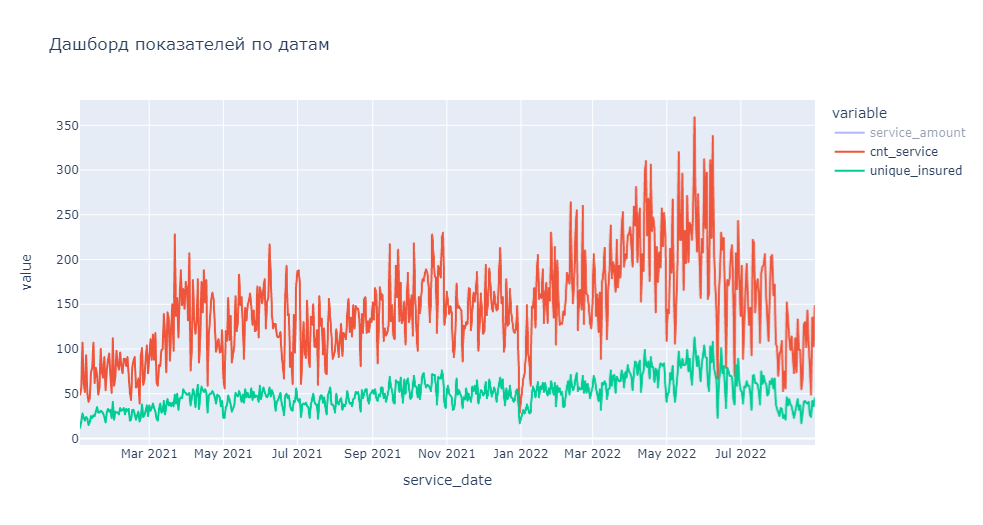

In [17]:
# для отображения карты plotly на github выведем рисунок
display(Image(filename='newplot.png', embed=True))

## Медицинский кейс

In [18]:
# датафрейм для расчёта медицинского кейса
data_med_case = (df.groupby(['service_date', 'insured','service_name','sex_id','age_for_service_date']).
 agg({'cnt_service':'sum','service_amount':'sum','service_year':'min'}).reset_index())

In [19]:
# медицинский кейс за 14 дней
start_date = (datetime.date(2022,1,1) - datetime.timedelta(days=7)).strftime('%Y-%m-%d')
end_date = (datetime.date(2022,1,1) + datetime.timedelta(days=7)).strftime('%Y-%m-%d')
mask = (data_med_case['service_date'] >= start_date) & (data_med_case['service_date'] <= end_date) 
display(data_med_case.loc[mask].query('insured == 512525'))
print('Стоимость медицинского кейса:', data_med_case.loc[mask].query('insured == 512525')['service_amount'].sum())

,service_date,insured,service_name,sex_id,age_for_service_date,cnt_service,service_amount,service_year
42347,2021-12-25,512525,АЛТ (аланинаминотрансфераза),1,34,1,290,2021-01-01
42348,2021-12-25,512525,АСТ (аспартатаминотрансфераза),1,34,1,250,2021-01-01
42349,2021-12-25,512525,Билирубин общий,1,34,1,300,2021-01-01
42350,2021-12-25,512525,Взятие крови из периферической вены,1,34,1,170,2021-01-01
42351,2021-12-25,512525,Креатинин,1,34,1,250,2021-01-01
42352,2021-12-25,512525,Креатинкиназа общая,1,34,1,250,2021-01-01
42353,2021-12-25,512525,"ЛПНП (липопротеиды низкой плотности, бета-липопротеиды)",1,34,1,300,2021-01-01
42354,2021-12-25,512525,Мочевая кислота,1,34,1,300,2021-01-01
42355,2021-12-25,512525,Триглицериды,1,34,1,300,2021-01-01
42356,2021-12-25,512525,Холестерин,1,34,1,300,2021-01-01


Стоимость медицинского кейса: 4090


## Обратившиеся за месяц

**Обратившийся в месяц - уникальное сочетание месяца оказания услуги и идентификатора пациента**

In [20]:
# добавим столбец с месяцем предоставления услуги
df['service_month'] = df['service_date'].to_numpy().astype('datetime64[M]')

# таблица обратившихся в месяц
applied_per_month = (df.groupby(['service_month','insured','sex_id','age_for_service_date']).
                     agg({'insured':'count','service_amount':'sum'}).rename(columns={'insured':'cnt_service'}).reset_index())

applied_per_month

,service_month,insured,sex_id,age_for_service_date,cnt_service,service_amount
0,2021-01-01,125073,0,65,7,9274
1,2021-01-01,125094,0,43,4,4479
2,2021-01-01,142427,1,34,20,38695
3,2021-01-01,142432,0,6,1,1470
4,2021-01-01,142438,1,25,16,14529
...,...,...,...,...,...,...
10728,2022-08-01,1306765,0,32,11,15412
10729,2022-08-01,1306768,0,22,35,34237
10730,2022-08-01,1306775,0,37,31,49361
10731,2022-08-01,1306792,0,27,39,63042


In [21]:
# таблица показателей по месяцам
month = (applied_per_month.groupby('service_month').
         agg({'insured':'nunique','sex_id':'mean','age_for_service_date':'mean','cnt_service':'sum','service_amount':'sum'}).
         reset_index())

# округлим показатели возраста и доли мужчин
month['sex_id'] = month['sex_id'].round(2)
month['age_for_service_date'] = month['age_for_service_date'].round(2)

# переименуем столбцы
month = month.rename(columns={'sex_id':'perc_of_man','age_for_service_date':'avg_age_for_month','insured':'unique_insured'})

In [ ]:
# дашборд показателей по месяцам(выбор показателя в легенде variable)
data = px.data.election()
fig = (px.bar(month, x='service_month', y=['service_amount','cnt_service','unique_insured','avg_age_for_month','perc_of_man'],
              title='Дашборд показателей за месяц'))
fig.update_xaxes(showticklabels=True)
fig.show() 

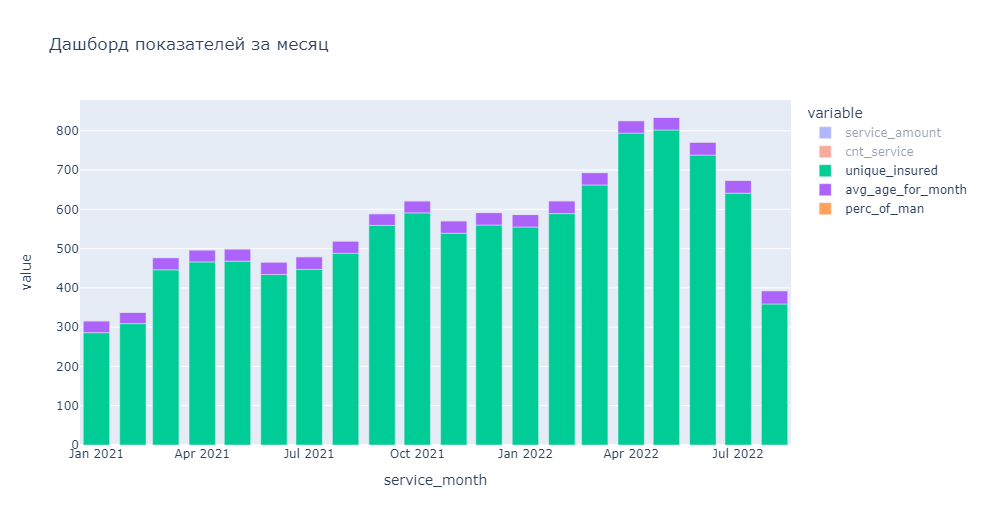

In [23]:
# для отображения карты plotly на github выведем рисунок
display(Image(filename='newplot1.png', embed=True))

## Анализ изменения цены лечения и выручки в 2022 году относительно 2021 года  

In [24]:
# добавим столбец с ценой 1 услуги
df['price'] = df['service_amount'] / df['cnt_service']

# таблица выручки по услугам
revenue = (df.groupby(['service_name', 'price', 'service_year']).
      agg({'service_amount':'sum'}).rename(columns={'service_amount':'revenue'})).reset_index()

# разделим таблицу с выручкой по годам
rev_21 = revenue.query('service_year == "2021-01-01"')
rev_22 = revenue.query('service_year == "2022-01-01"')

In [25]:
print('Сумма выручки за 2021 год:', rev_21['revenue'].sum())
print('Сумма выручки за 8 месяцев 2022 года:', rev_22['revenue'].sum())

Сумма выручки за 2021 год: 50556105
Сумма выручки за 8 месяцев 2022 года: 48986662


In [26]:
# ТОП-10 услуг по выручке в 2021 году
top_10_rev_21 = rev_21.sort_values('revenue', ascending=False).head(10)
top_10_rev_21

,service_name,price,service_year,revenue
1387,Прием первичный,1470.0,2021-01-01,7738080
1390,Прием повторный,1313.0,2021-01-01,5069493
1388,Прием первичный,1540.0,2021-01-01,1218140
935,Магнитотерапия (1 сеанс),1040.0,2021-01-01,964080
1391,Прием повторный,1380.0,2021-01-01,847320
801,Комплексная мануальная терапия,3150.0,2021-01-01,844200
1052,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693.0,2021-01-01,805959
1739,Сеанс рефлексотерапии,1827.0,2021-01-01,610218
1935,Ультразвуковое исследование гинекология трансвагинально с ДС сосудов,2100.0,2021-01-01,571200
1917,Ультразвуковое исследование брюшной полости,2100.0,2021-01-01,510300


In [27]:
# ТОП-10 услуг по выручке за 8 месяцев в 2022 году
top_10_rev_22 = rev_22.sort_values('revenue', ascending=False).head(10)
top_10_rev_22

,service_name,price,service_year,revenue
1443,"Прием трапевта, первичный",1540.0,2022-01-01,1245860
937,Магнитотерапия (1 сеанс),1090.0,2022-01-01,1244780
1303,"Прием гинеколога, повторный",1380.0,2022-01-01,1065360
803,Комплексная мануальная терапия,3310.0,2022-01-01,959900
1365,"Прием отоларинголога, первичный",1540.0,2022-01-01,947100
1054,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",730.0,2022-01-01,894250
1937,Ультразвуковое исследование гинекология трансвагинально с ДС сосудов,2210.0,2022-01-01,870740
1345,"Прием невролога, первичный",1540.0,2022-01-01,863940
1374,"Прием офтальмолога, первичный",1540.0,2022-01-01,651420
1429,"Прием терапевта , повторный",1380.0,2022-01-01,645840


**Остаются в ТОП-10 по выручке 2021-2022 год:**

- Магнитотерапия (1 сеанс)
- Комплексная мануальная терапия
- Общий анализ крови (лейкоцитарная форм,, СОЭ)
- Ультразвуковое исследование гинекология трансвагинально с ДС сосудов	

In [28]:
# ТОП-10 услуг по цене в 2021 году
top_10_rev_21 = rev_21.sort_values('price', ascending=False).head(10)
top_10_rev_21

,service_name,price,service_year,revenue
2160,"гистерорезектоскопия при полипах , РДВ",26999.0,2021-01-01,26999
893,МРТ брюшной полости и забрюшинного пространства с внутривенным контрастированием,17325.0,2021-01-01,17325
897,МРТ головного мозга и гипофиза с контрастированием,15225.0,2021-01-01,15225
982,Мультипараметрическая МРТ предстательной железы с динамическим контрастированием,14175.0,2021-01-01,14175
909,МРТ органов малого таза с внутривенным контрастированием,13780.0,2021-01-01,13780
926,МСКТ органов брюшной полости и забрюшинного пространства с внутривенным болюсным контрастированием,12680.0,2021-01-01,25360
923,МСКТ мочевыделительной системы с внутривенным болюсным контрастированием,12075.0,2021-01-01,12075
1827,Тотальная внутривенная анестезия от 20 минут до 60 минут,11550.0,2021-01-01,11550
930,МСКТ почек и надпочечников с внутривенным болюсным контрастированием,11025.0,2021-01-01,11025
900,МРТ головного мозга с контрастированием,9920.0,2021-01-01,9920


In [29]:
# ТОП-10 услуг по цене в 2022 году
top_10_rev_22 = rev_22.sort_values('price', ascending=False).head(10)
top_10_rev_22

,service_name,price,service_year,revenue
2123,"Эндоскопическая полипэктомия 2-й категории ( от 0,6 до 1,0см )",9700.0,2022-01-01,9700
344,"Вакцинация вакциной ""Менактра""",9000.0,2022-01-01,9000
2064,Хирургическое удаление доброкачественной опухоли кожи,8400.0,2022-01-01,25200
423,Вскрытие панариция,8400.0,2022-01-01,8400
924,МСКТ мягких тканей шеи с фонацией,8270.0,2022-01-01,8270
2063,Хирургическое удаление доброкачественной опухоли кожи,8050.0,2022-01-01,8050
422,Вскрытие панариция,8050.0,2022-01-01,24150
912,МРТ плечевого сустава,7720.0,2022-01-01,7720
915,МРТ тазобедренных суставов,7720.0,2022-01-01,7720
1870,Удаление вросшего ногтя,7280.0,2022-01-01,7280


**Исследуем выбросы в выручке за 2021 год**

In [30]:
# выбросы в выручке за 2021
print(rev_21[rev_21['service_name'] == "Прием первичный"])
print(rev_21[rev_21['service_name'] == "Прием повторный"])

         service_name   price service_year  revenue
1387  Прием первичный  1470.0   2021-01-01  7738080
1388  Прием первичный  1540.0   2021-01-01  1218140
1389  Прием первичный  1755.0   2021-01-01     1755
         service_name   price service_year  revenue
1390  Прием повторный  1313.0   2021-01-01  5069493
1391  Прием повторный  1380.0   2021-01-01   847320


**Первичный и повторный приёмы принесли в 2021 году приблизительно 9 и 6 млн выручки соответственно. Для улучшения сравнения графиков выручки 2021 и 2022 года изменим масштаб, убрав выбросы**

In [ ]:
# распределения выручки в 2021 году без "выбросов"
rev_21 = rev_21.query('service_name != "Прием первичный" & service_name != "Прием повторный"')

# дашборд цены и выручки 2021 год(выбор показателя в легенде variable)
data = px.data.election()
fig = (px.line(rev_21, x='service_name', y=['price','revenue'],
               title='Дашборд цены и выручки за 2021 год'))
fig.update_xaxes(showticklabels=False)
fig.show() 

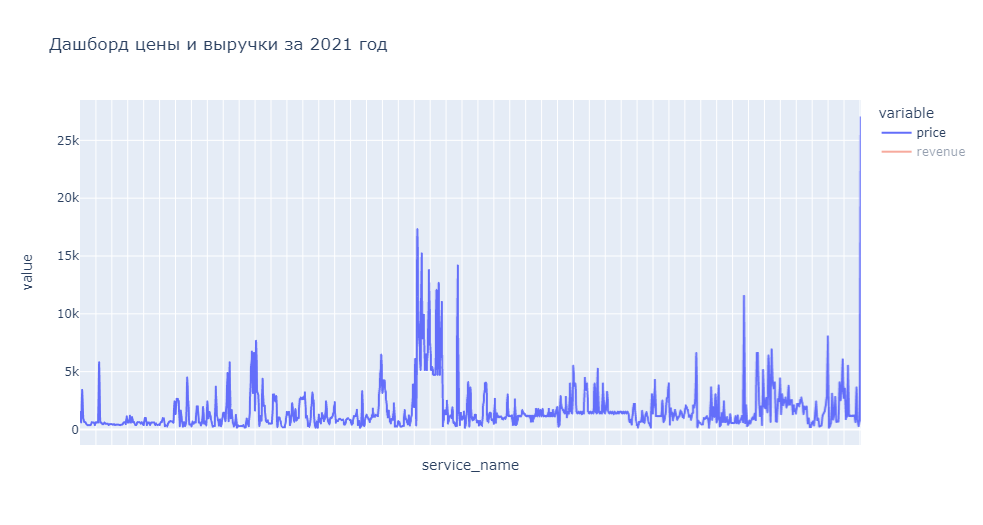

In [32]:
# для отображения карты plotly на github выведем рисунок
display(Image(filename='newplot2.png', embed=True))

In [ ]:
# дашборд цены и выручки 2022 год(выбор показателя в легенде variable)
data = px.data.election()
fig = (px.line(rev_22, x='service_name', y=['price','revenue'],
               title='Дашборд цены и выручки за 2022 год'))
fig.update_xaxes(showticklabels=False)
fig.show() 

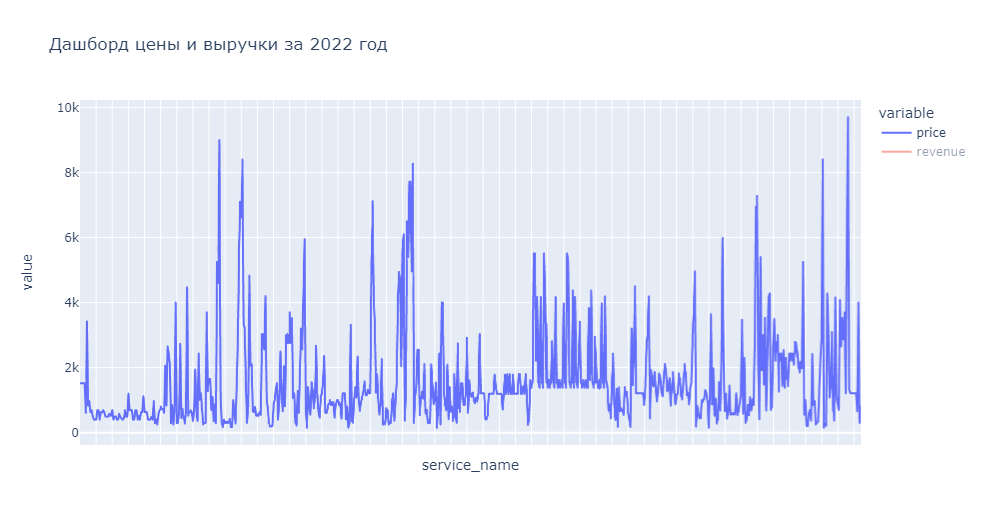

In [34]:
# для отображения карты plotly на github выведем рисунок
display(Image(filename='newplot3.png', embed=True))

## Исследование изменения стоимости услуг

In [35]:
# стоимость услуг в 2021
df_2021 = df.query('service_year == "2021-01-01"')
df_2021 = df_2021.rename(columns={'price':'price_2021'})
df_service_amount_2021 = df_2021[['service_name','price_2021']].reset_index(drop=True)
df_service_amount_2021

,service_name,price_2021
0,Прием первичный,1470.0
1,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284.0
2,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134.0
3,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693.0
4,Ревматоидный фактор,420.0
...,...,...
44383,Взятие секрета предстательной железы,380.0
44384,Взятие мазка,360.0
44385,Урофлуометрия,950.0
44386,Исследование сока простаты,460.0


In [36]:
# стоимость услуг в 2022
df_2022 = df.query('service_year == "2022-01-01"')
df_2022 = df_2022.rename(columns={'price':'price_2022'})
df_service_amount_2022 = df_2022[['service_name','price_2022']].reset_index(drop=True)
df_service_amount_2022

,service_name,price_2022
0,Магнитотерапия (1 сеанс),1090.0
1,СМТ-форез (1 сеанс) (2 поля),950.0
2,"Прием невролога, повторный",1380.0
3,Магнитотерапия (1 сеанс),1090.0
4,"Прием физиотерапевта, повторный",1380.0
...,...,...
40972,Общий анализ мочи,495.0
40973,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",800.0
40974,АЧТВ (активированное частичное тромбопластиновое время),300.0
40975,Протромбин (МНО),410.0


In [37]:
# объединённая таблица стоимости услуг по годам
report = df_service_amount_2021.merge(df_service_amount_2022, on='service_name')
report = report.drop_duplicates().reset_index(drop=True)
report.head()

,service_name,price_2021,price_2022
0,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284.0,300.0
1,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284.0,330.0
2,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",300.0,300.0
3,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",300.0,330.0
4,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134.0,1190.0


**Поскольку цена на услуги изменялась несколько раз за год, посчитаем среднюю стоимость**

In [38]:
# таблица средней стоимости услуг за 2021 и 2022 год
price_2021_2022 = report.groupby('service_name').agg({'price_2021':'mean', 'price_2022':'mean'}).reset_index()
price_2021_2022

,service_name,price_2021,price_2022
0,"(Б1 (11))Аллергопанель IgE шерсть кошки, шерсть собаки, шерсть овцы, клещ D,pteroniss, клещ D.farina, пыль домашняя, перо подушки, библиотечная пыль)",1484.5,1520.0
1,17-OH - гидроксипрогестерон,610.0,610.0
2,25-OH витамин D (25-гидроксихолекальциферол),3337.5,3420.0
3,Bordetella (pertusis) IgA,970.0,970.0
4,Bordetella (pertusis) IgG,630.0,660.0
...,...,...,...
538,Эпителий собаки,1182.5,1210.0
539,Эстрадиол,645.0,680.0
540,Эхокардиография с допплеровским анализом,3552.5,3820.0
541,альфа-амилаза,293.5,315.0


In [39]:
# добавим % изменения средней стоимости
price_2021_2022['perc'] = round((price_2021_2022['price_2022'] - price_2021_2022['price_2021']) /
              price_2021_2022['price_2021'] * 100, 2)

price_2021_2022

,service_name,price_2021,price_2022,perc
0,"(Б1 (11))Аллергопанель IgE шерсть кошки, шерсть собаки, шерсть овцы, клещ D,pteroniss, клещ D.farina, пыль домашняя, перо подушки, библиотечная пыль)",1484.5,1520.0,2.39
1,17-OH - гидроксипрогестерон,610.0,610.0,0.00
2,25-OH витамин D (25-гидроксихолекальциферол),3337.5,3420.0,2.47
3,Bordetella (pertusis) IgA,970.0,970.0,0.00
4,Bordetella (pertusis) IgG,630.0,660.0,4.76
...,...,...,...,...
538,Эпителий собаки,1182.5,1210.0,2.33
539,Эстрадиол,645.0,680.0,5.43
540,Эхокардиография с допплеровским анализом,3552.5,3820.0,7.53
541,альфа-амилаза,293.5,315.0,7.33


Text(0, 0.5, 'Количество услуг')

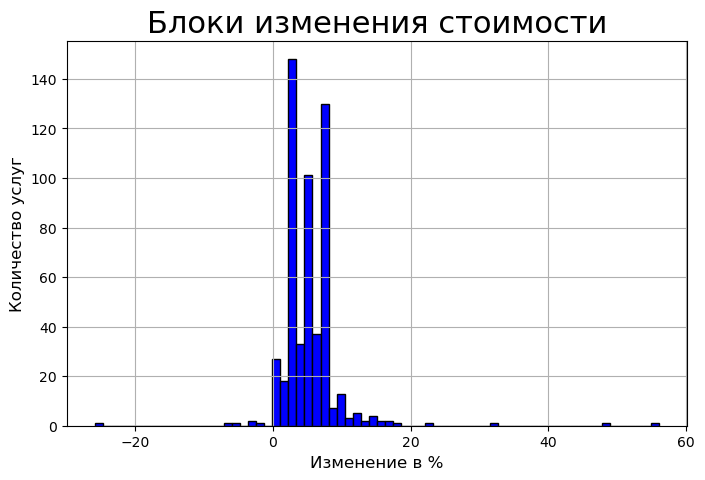

In [53]:
# распределение изменения стоимости(в %) по количеству 
price_2021_2022['perc'].hist(bins=70, figsize=(8, 5), ec='black', color='blue')
plt.title('Блоки изменения стоимости', fontsize=22)
plt.xlabel('Изменение в %', fontsize=12)
plt.ylabel('Количество услуг', fontsize=12)

### Интерактивный график изменения стоимости

In [ ]:
# дашборд изменения стоимости в %
data = px.data.election()
fig = px.bar(price_2021_2022, x='service_name', y='perc', title='Изменения стоимости в 2022 году', width=1000,
    height=600, color='perc')
fig.update_xaxes(showticklabels=False)
fig.show() 

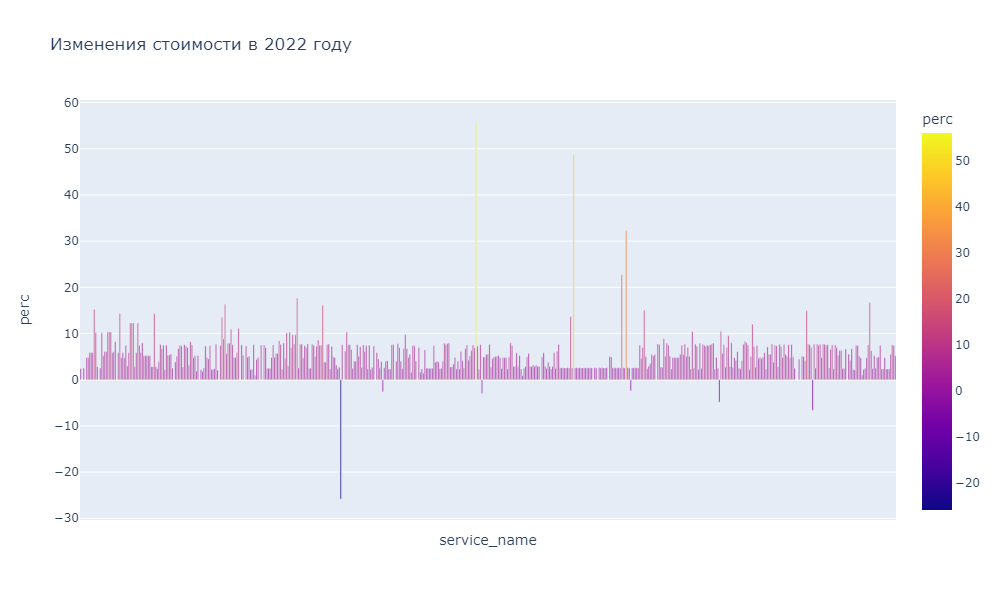

In [42]:
# для отображения карты plotly на github выведем рисунок
display(Image(filename='newplot4.png', embed=True))

**По графику хорошо видно, что сильнее всего подорожал анализ крови, первичный приём дерматолога, первичный и повторный приём терапевта.**

In [43]:
price_2021_2022['perc'].describe()

count    543.000000
mean       5.212855
std        4.598154
min      -25.830000
25%        2.540000
50%        4.900000
75%        7.370000
max       56.010000
Name: perc, dtype: float64

**В среднем цены на услуги в 2022 году выросли на 5,2%**

### Наиболее подорожавшие услуги

In [44]:
price_2021_2022.query('perc >= 8').sort_values('perc', ascending=False)

,service_name,price_2021,price_2022,perc
263,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",711.500000,1110.000000,56.01
328,"Прием дерматолога, первичный",1540.000000,2291.250000,48.78
363,"Прием трапевта, первичный",1540.000000,2036.666667,32.25
360,"Прием терапевта , повторный",1380.000000,1693.333333,22.71
144,Дуплексное сканирование вен нижних конечностей,2692.500000,3166.666667,17.61
525,Экспресс - метод определения кампилобактера/хеликобактера в биоптате слизистой,680.000000,793.333333,16.67
96,Взятие мазка,328.333333,382.000000,16.35
161,Интерпретация результатов Диаскинтеста,1103.000000,1280.000000,16.05
9,Chlamydia pneumoniae IgG,599.000000,690.000000,15.19
375,Проведение Диаскинтеста,1365.000000,1570.000000,15.02


### Неподорожавшие услуги

In [45]:
# неподорожавшие услуги
price_2021_2022.query('perc <= 0').sort_values('perc')

,service_name,price_2021,price_2022,perc
173,Исследование мокроты,809.000000,600.000000,-25.83
487,Ультразвуковое исследование гинекология абдоминально,1935.000000,1806.666667,-6.63
425,Рентгенография шейного отдела позвоночника (2 снимка),1686.666667,1605.000000,-4.84
267,Осмотр кожи под увеличением (дерматоскопия),735.333333,713.333333,-2.99
201,Классический лечебный массаж спины,1596.666667,1555.000000,-2.61
366,"Прием физиотерапевта, первичный",1540.000000,1503.333333,-2.38
479,"Удаление радиохирургическим ножом беспигментного невуса свыше 0,5 см",4170.000000,4170.000000,0.00
477,Удаление ногтевой пластины,3530.000000,3530.000000,0.00
476,"Удаление кожных образований хирургическим путем 1ед, на теле (диаметром до 0.5 см.)",1480.000000,1480.000000,0.00
383,Промывание конъюнктивной полости,540.000000,540.000000,0.00


## Проверка гипотез

In [46]:
df_2021 = df.query('service_year == "2021-01-01"')
df_2022 = df.query('service_year == "2022-01-01"')

### Гипотеза 1

- **H0** - Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги
- **H1** - Средняя стоимость обслуживания пациентов не изменилась из-за изменения цен на услуги

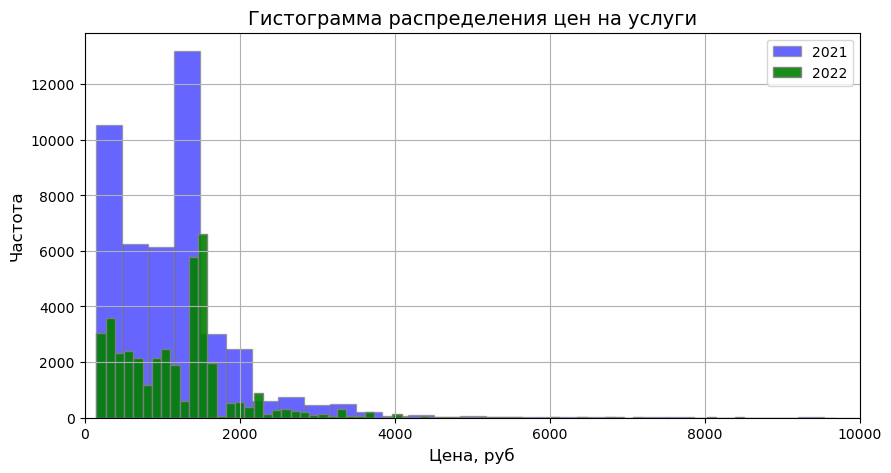

In [47]:
# график распределения
ax = df_2021['price'].plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0,label='2021',color='blue',alpha=0.6,ec='grey')
df_2022['price'].plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0, ax=ax,color='green',alpha=0.9,label='2022',ec='grey')
plt.title("Гистограмма распределения цен на услуги", fontsize=14)
plt.xlabel("Цена, руб", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xlim(0, 10000)
ax.legend()
plt.show()

Распределение не нормальное

In [48]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df_2021['price'], df_2022['price'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 1.744661396567026e-29
Отвергаем нулевую гипотезу: разница статистически значима


**Нельзя утверждать, что средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги**

### Гипотеза 2

- **H0** - Средняя стоимость обслуживания пациентов изменилась из-за изменения гендерной структуры обслуживаемых пациентов
- **H1** - Средняя стоимость обслуживания пациентов не изменилась из-за изменения гендерной структуры обслуживаемых пациентов

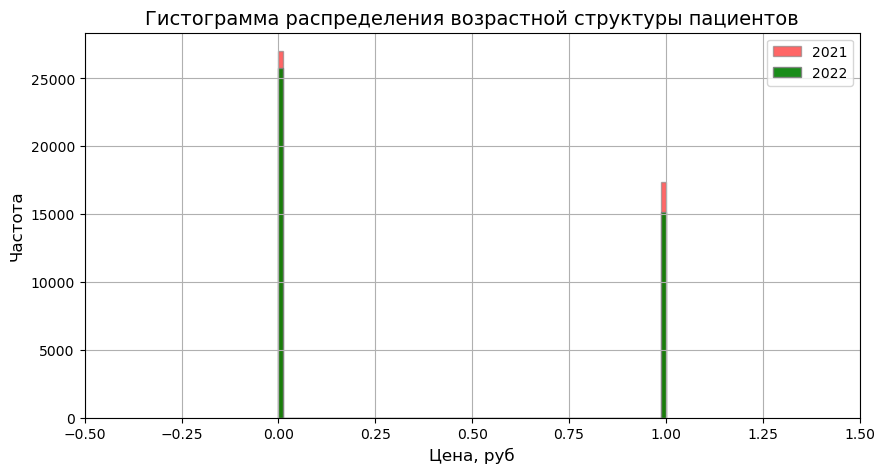

In [49]:
# график распределения
ax = df_2021['sex_id'].plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0,label='2021',color='red',alpha=0.6,ec='grey')
df_2022['sex_id'].plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0, ax=ax,color='green',alpha=0.9,label='2022',ec='grey')
plt.title("Гистограмма распределения возрастной структуры пациентов", fontsize=14)
plt.xlabel("Цена, руб", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xlim(-0.5, 1.5)
ax.legend()
plt.show()

In [50]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df_2021['sex_id'], df_2022['sex_id'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 5.499432434287437e-10
Отвергаем нулевую гипотезу: разница статистически значима


**Нельзя утверждать, что средняя стоимость обслуживания пациентов изменилась из-за изменения гендерной структуры обслуживаемых пациентов**

### Гипотеза 3

- **H0** - Средняя стоимость обслуживания пациентов изменилась из-за изменения возрастной структуры пациентов
- **H1** - Средняя стоимость обслуживания пациентов не изменилась из-за изменения возрастной структуры пациентов

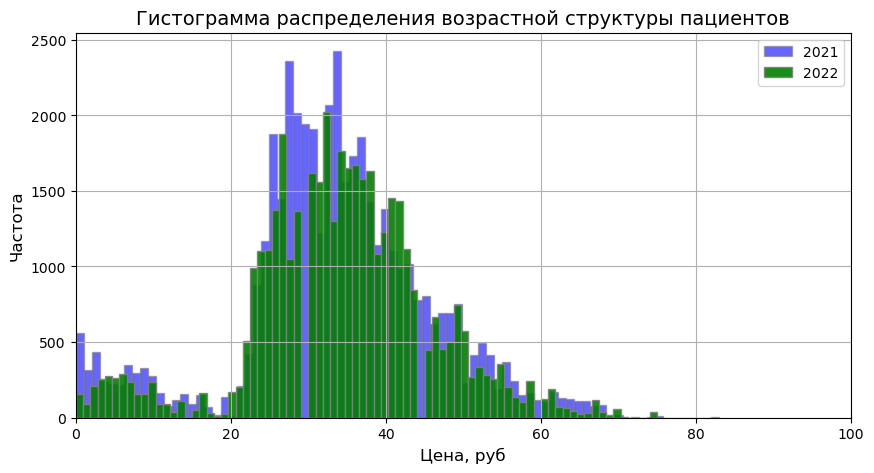

In [51]:
# график распределения
ax = (df_2021['age_for_service_date'].
      plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0,label='2021',color='blue',alpha=0.6,ec='grey'))

(df_2022['age_for_service_date'].
 plot(kind='hist',bins=80,figsize=(10,5),grid=True,rot=0, ax=ax,color='green',alpha=0.9,label='2022',ec='grey'))

plt.title("Гистограмма распределения возрастной структуры пациентов", fontsize=14)
plt.xlabel("Цена, руб", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xlim(0, 100)
ax.legend()
plt.show()

Распределение не нормальное

In [52]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df_2021['age_for_service_date'], df_2022['age_for_service_date'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 1.3090341765613492e-16
Отвергаем нулевую гипотезу: разница статистически значима


**Нельзя утверждать, что средняя стоимость обслуживания пациентов изменилась из-за изменения возрастной структуры пациентов**